# Amazon Recommender System
![amazon](./images/amazon.png)

# Overview
Amazon is interested in building a new personalized recommendation system. Visualizations and text summaries are included at the end.

#  Business Problem
It is found that 35% of Amazon's revenue is from the recommendation system ([link](https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers)). Amazon offers various recommendations based on popularity, purchase history, browsing history, etc. However, Amazon does not offer a recommendation system built based on customer ratings. While the market size for video gaming is increasing ([link](https://www.ibisworld.com/industry-statistics/market-size/video-games-united-states/)), this analysis will show you how we can build a personalized system for **video games** using customers' ratings.

# Data Understanding
There are two datasets, review data and metadata. If the download links below do not work, the files can be downloaded from this [link](https://nijianmo.github.io/amazon/index.html). Both data have information from the year 1996 till 2018.

## Review Data
The review data has customer id, game item id, and ratings.

In [1]:
# import library
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.ticker import FuncFormatter

import code.visualizations as viz

In [2]:
df = pd.read_csv('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games.csv', 
                 names=['item', 'user', 'rating', 'timestamp'])

# changing column orders
# drop unnecessary column
df = df[['user', 'item', 'rating']]

# update datatype for rating values
df.rating = df.rating.astype('int32')

In [3]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   user    object
 1   item    object
 2   rating  int32 
dtypes: int32(1), object(2)
memory usage: 48.9+ MB


In [4]:
# print the first 5 rows
df.head()

,user,item,rating
0,A21ROB4YDOZA5P,0439381673,1
1,A3TNZ2Q5E7HTHD,0439381673,3
2,A1OKRM3QFEATQO,0439381673,4
3,A2XO1JFCNEYV3T,0439381673,1
4,A19WLPIRHD15TH,0439381673,4


Every rating value is integers from 1 to 5.

In [5]:
df.rating.value_counts()

5    1487366
4     412413
1     311891
3     212346
2     141333
Name: rating, dtype: int64

There is no missing values.

In [6]:
df.isna().sum()

user      0
item      0
rating    0
dtype: int64

More than half of the ratings are 5.

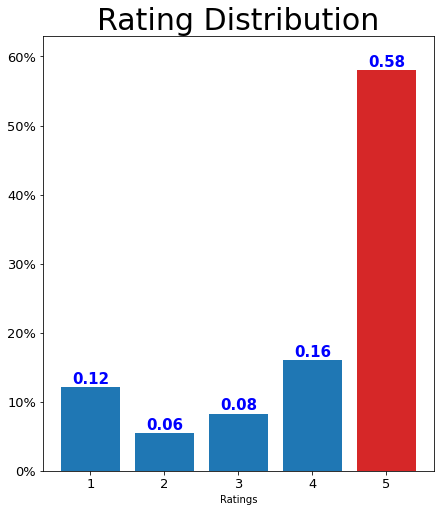

In [7]:
review_dist = pd.DataFrame(df.rating.value_counts(normalize = True)).reset_index().sort_values(by = 'index')
review_dist.rename(columns = {'index': 'review_rating', 'rating':'percentage'}, inplace = True)

# show rating distribution
viz.result_1(review_dist)

## Metadata

This data contains information on video games. The selected information is the brand name, category, game item id, and game title. This data will help print out the game titles and organize the information gained from the analysis.

### Cleaning metadata

Brand names will be formatted to simplify the names.

In [8]:
import gzip
import json

# reading json file line by line
df_meta = pd.read_json('http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Video_Games.json.gz', 
                    lines=True)

# select relevant columns only
df_meta_basic = df_meta[['title', 'asin', 'category', 'brand']]

# formatting brand names
df_meta_basic['brand'] = df_meta_basic['brand'].str.replace("\n", "")
df_meta_basic['brand'] = df_meta_basic['brand'].str.replace("by", "")
df_meta_basic['brand'] = df_meta_basic['brand'].str.replace(" ", "")
df_meta_basic['brand'] = df_meta_basic['brand'].str.lower()

Duplicate rows are checked and then removed.

In [9]:
# checking duplicates
df_meta_basic.duplicated(subset=['asin']).value_counts()

False    71911
True     12908
dtype: int64

In [10]:
# drop duplicates
df_meta_basic.drop_duplicates(subset=['asin'], inplace = True)

## Combine Multiple Information
This would be a huge step. Information from review data will be added to the metadata, and then many columns of categories will be also added to the metadata.

### Adding Mean of Ratings
Mean of ratings from review data will be calculated and then assigined to each video game in the metadata.

In [11]:
# Calculate mean ratings for each item
rating_avg_df = df.groupby('item').mean().reset_index()

# rename column names for easier merging with meta data
rating_avg_df.rename(columns = {'rating' : 'avg_rating', 
                                'item' : 'asin'}, 
                     inplace = True)

# assign mean ratings to each item using merging
df_meta_final = pd.merge(df_meta_basic, rating_avg_df, on='asin', how='inner')

df_meta_final

,title,asin,category,brand,avg_rating
0,Reversi Sensory Challenger,0042000742,"[Video Games, PC, Games]",fidelityelectronics,5.000000
1,Medal of Honor: Warfighter - Includes Battlefi...,0078764343,"[Video Games, Xbox 360, Games, </span></span><...",eagames,4.750000
2,street fighter 2 II turbo super nintendo snes ...,0276425316,"[Video Games, Retro Gaming & Microconsoles, Su...",nintendo,5.000000
3,Xbox 360 MAS STICK,0324411812,"[Video Games, Xbox 360, Accessories, Controlle...",massystems,1.000000
4,Phonics Alive! 3: The Speller,0439335310,"[Video Games, PC, Games, </span></span></span>...",advancedsoftwarepty.ltd.,3.000000
...,...,...,...,...,...
71904,Lego Star Wars: The Force Awakens - PS Vita [D...,B01HJ1521Y,"[Video Games, PlayStation Vita, Digital Games ...",warnerbros.,5.000000
71905,Lego Star Wars: The Force Awakens Season Pass...,B01HJ14TTA,"[Video Games, PlayStation 4, Digital Games & D...",warnerbros.,3.000000
71906,The Technomancer - PS4 [Digital Code],B01HJ14OT0,"[Video Games, PlayStation 4, Digital Games & D...",focushomeinteractive,5.000000
71907,"Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...",B01HJC33WS,"[Video Games, Xbox 360, Accessories, </span></...",yttl,4.590909


### Adding Columns for Console Names and Brand Names
Later in the analysis, I will be discussing "similarity". To calculate similarity, we need more specific information. This step will try to gain console information and brand names. Each console name or brand name will be added as a column name. This will tell us if a game item belongs to a console name or a brand name.

In [12]:
# a function to get console information from category column
# this will try to search console name by looping category values
def find_cat(df, cat):
    length = []
    for i in df.index:
        text_list = df.iloc[i].category
        length.append(len([t for t in text_list if cat in t.replace(" ", "").lower()]))
    return pd.DataFrame(length, columns = [cat])

In [13]:
# Console names to be searched
console = ['pc', 'xbox', 'xbox360', 'xboxone', 
 'playstation', 'playstation2', 'playstation3', 'playstation4', 
 'cube', 'wii', 'switch', 'nintendo',
 'accessories', 
]

# Select 30 brand names with the highest counts
# control the number of columns
brand = df_meta_final.brand.value_counts().head(30).index

# search each console name and add each to the metadata as a new column
for c in console:
    example = find_cat(df_meta_final, c)
    # If a name is found multiplel times, set it to 1
    example[c] = example[c].map(lambda x: 1 if x >= 1 else 0)
    df_meta_final = pd.concat([df_meta_final, example], axis = 1)

# search each brand name and add each to the metadata as a new column
for b in brand:
    df_meta_final[b] = df_meta_final.brand.map(lambda x: 1 if x == b else 0)
    
# drop original columns
df_meta_final.drop(['category', 'brand'], axis = 1, inplace = True)

In [14]:
df_meta_final.columns

Index(['title', 'asin', 'avg_rating', 'pc', 'xbox', 'xbox360', 'xboxone',
       'playstation', 'playstation2', 'playstation3', 'playstation4', 'cube',
       'wii', 'switch', 'nintendo', 'accessories', '', 'electronicarts',
       'activision', 'sony', 'ubisoft', 'sega', 'microsoft', 'atari', 'thq',
       'konami', 'capcom', 'squareenix', 'madcatz', 'bandai', '2k', 'encore',
       'generic', 'dreamgear', 'intec', 'vivamedia', 'vivendiuniversal',
       'wbgames', 'skinit', 'unknown', 'wraptorskinz', 'modfreakz', 'midway',
       'hori'],
      dtype='object')

# Analysis 1 - Building a System
This part will explain how customers would rate the game items they have not rated.

## Train-test-split
The data is split into train data and test data. A model will be trained and validated using train data, and prediction rating will be calculated using test data.

In [15]:
# selecting X and y
X = df[df.columns[:2]]
y = df[df.columns[-1]]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [16]:
from surprise import Reader, Dataset
# read in values as Surprise dataset 
reader = Reader()
# train data
# Loading the data again for the Surprise library
train = Dataset.load_from_df(pd.concat([X_train, y_train], axis = 1), reader)
# test data
# Loading the data again for the Surprise library
test = Dataset.load_from_df(pd.concat([X_test, y_test], axis = 1), reader)
# whole data for comparison
data = Dataset.load_from_df(df, reader)

In [17]:
# summary of the whole data
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  1540618 

Number of items:  71982


In [18]:
# summary of the train data
train_set = train.build_full_trainset()
print('Number of users: ', train_set.n_users, '\n')
print('Number of items: ', train_set.n_items)

Number of users:  1139782 

Number of items:  65479


In [19]:
# summary of the test data
test_set = test.build_full_trainset()
print('Number of users: ', test_set.n_users, '\n')
print('Number of items: ', test_set.n_items)

Number of users:  644499 

Number of items:  53651


## Baseline Model and Final Model
Analysis will use surprise library to estimate expected ratings. The validation had been checked using RMSE. The whole steps finding the final model is found at **EDA_baseline_model_and_finalized_model_selection.ipynb**. This is a major step building a personalized recommendation system.

### Collaborative Filtering
Collaborative filtering uses a matrix factorization. This will check relationship between each items or between each customers.

In [20]:
# importing relevant libraries
import surprise
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
import numpy as np

In [21]:
svd = SVD(random_state = 0)
val_svd = cross_validate(svd, train, measures=['RMSE', 'MAE'], cv=3)
print("Mean RMSE for the baseline model validation:")
np.mean(val_svd['test_rmse'])

Mean RMSE for the baseline model validation:


1.2976121732662644

In [22]:
svd = SVD(random_state = 0).fit(train_set)

pred = []
for i in range(len(X_test)):
    pred.append(svd.predict(X_test.iloc[i].values[0], X_test.iloc[i].values[1])[3])
    
from sklearn.metrics import mean_squared_error
print("RMSE for the baseline model on test data:")
print(mean_squared_error(y_test, pred, squared=False))

RMSE for the baseline model on test data:
1.282665736278365


In [23]:
svd = SVD(random_state = 0, 
          n_factors= 100, 
          reg_all = 0.07, 
          n_epochs = 150)

val_svd = cross_validate(svd, train, measures=['RMSE', 'MAE'], cv=3)
print("Mean RMSE for the final model validation:")
np.mean(val_svd['test_rmse'])

Mean RMSE for the final model validation:


1.2848607806625232

In [24]:
svd = SVD(random_state = 0, 
          n_factors= 100, 
          reg_all = 0.07, 
          n_epochs = 150).fit(train_set)
pred = []
for i in range(len(X_test)):
    pred.append(svd.predict(X_test.iloc[i].values[0], X_test.iloc[i].values[1])[3])
    
from sklearn.metrics import mean_squared_error
print("RMSE for the final model on test data:")
print(mean_squared_error(y_test, pred, squared=False))

RMSE for the final model on test data:
1.265958695728431


The RMSE for the final model is lowered.

# Analysis 2 - Comparison
This step will make a comparison between predicted ratings and given ratings on 500 randomly selected customers. Each customer will have a unique list of video games, and each video game will be assigned with a mean given rating (popularity) and a predicted rating. T-test will be used to make a comparison of two rating types, and p-values less than 0.05 will prove the difference of two rating types.

In [25]:
from scipy import stats

In [26]:
# function to make a prediction on one user and a list of game items
# returns a dataframe with a column of item numbers and a numbered column of predicted ratings
# Since 500 customers will be selected, n will go upto 499 from 0.
def pred_data(test_user, n):
    game_rating_list = []
    for g in uniq_game_list:
        game_rating_list.append((g, svd.predict(test_user, g)[3]))
    return pd.DataFrame(game_rating_list, columns = ['asin', 'rating_pred_'+ str(n)])

In [27]:
# df - review data
list_ = df.user.value_counts()

# a unique list of games
uniq_game_list = df['item'].unique()

# a list of 500 randomly selected customers
# Customers with at least 5 given ratings are selected to avoid too much sampling
# from customers with low number of ratings
# Majority of customers have given ratings less than 5.
list_5_or_more = list_[list_ >= 5].sample(500, random_state = 0)
list_5_or_more_index = list_5_or_more.index
# Predcted ratings are merged to the meta data
for i, user in enumerate(list_5_or_more_index):
    df_meta_final = pd.merge(df_meta_final, pred_data(user, i), on='asin', how='inner')

# get p-values for all of the selected customers    
p = []
len_user = len(list_5_or_more_index)
for l in range(len_user):
    p_i = []
    c_name = "rating_pred_" + str(l)
    for i in range(10):
        df_meta_sample = df_meta_final.sample(50, random_state = i)
        # t-test predicted rating vs. average given rating (popularity)
        # P-values are merged to the metadata
        p_u = stats.ttest_ind(df_meta_sample[c_name], df_meta_final.avg_rating)[1]
        p_i.append(p_u)
    p.append(np.mean(p_i))

In [28]:
list_5 = list_5_or_more.reset_index()
list_5['p_value'] = p

# Result 1 - P-values
- Majority of p-values are populated below 0.05.

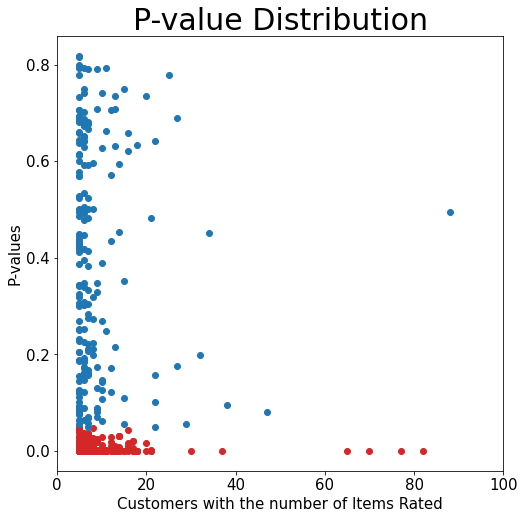

In [29]:
# distribution of p-values
viz.result_2(list_5)

- More than 60% of customers would have different shopping experience.

In [30]:
print("The number of customers with significantly low p-values:")
len(list_5[list_5.p_value <= 0.05])

The number of customers with significantly low p-values:


301

# Analysis 3 - Hybrid Filtering
The graph below shows one of the extreme cases where one user can have more than 15,000 predicted rating values equal to or close to 5. This would be tough to choose 20 to 30 games to be displayed on the first page of a personalized recommendation list. In this case, we can use [hybrid filtering](https://towardsdatascience.com/recommendation-systems-explained-a42fc60591ed#:~:text=Resources-,What%20is%20a%20Recommendation%20System,give%20to%20a%20specific%20item.). Hybrid filtering can use any combination of recomomendation systems, and I have used two systems combined in this analysis. One of the two is collaborative filtering system discussed in the earlier section. The other is to use content-based system (similarity). Using a similarity value that scales from 0 to one, we can find items similar to one of the selected games.

In [31]:
# select a user
test_user_picked = 'A2FD1GFHUH73Y5'

rating_pred_df = pred_data(test_user_picked, 1000)
df_meta_final = pd.merge(df_meta_final, rating_pred_df, on='asin', how='inner')

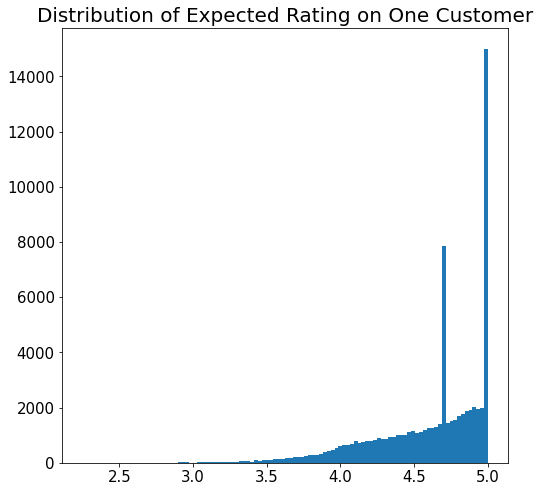

In [32]:
viz.result_3(df_meta_final.rating_pred_1000)

## Similarity
We need to choose one game first.

In real life, we would allow a customer to choose a game the customer actually rated, but the selected game can be anything to show the python code works to check the similarity.

In [33]:
df_meta_final[df_meta_final.asin == 'B01GW8XLCM']['title']

71500    Resident Evil 7 Biohazard - Xbox One
Name: title, dtype: object

In [34]:
# relevant columns for similarity
df_meta_final.columns[3:44]

Index(['pc', 'xbox', 'xbox360', 'xboxone', 'playstation', 'playstation2',
       'playstation3', 'playstation4', 'cube', 'wii', 'switch', 'nintendo',
       'accessories', '', 'electronicarts', 'activision', 'sony', 'ubisoft',
       'sega', 'microsoft', 'atari', 'thq', 'konami', 'capcom', 'squareenix',
       'madcatz', 'bandai', '2k', 'encore', 'generic', 'dreamgear', 'intec',
       'vivamedia', 'vivendiuniversal', 'wbgames', 'skinit', 'unknown',
       'wraptorskinz', 'modfreakz', 'midway', 'hori'],
      dtype='object')

In [35]:
# Select a game
test_index = df_meta_final[df_meta_final.asin == 'B01GW8XLCM'].index[0]
len_meta = len(df_meta_final)

# pick columns of console names and brand names
df_matrix = df_meta_final[df_meta_final.columns[3:44]]
# transpose before dot product
df_matrix_t = df_matrix.T
# product of selected game and whole matrix
numerator = df_matrix_t[test_index].dot(df_matrix_t)

# product of 
# sqrt of sum of all squared values for the selected game
# and
# sqrt of sum of all squared values for each game
denominator = [np.sqrt(sum(df_matrix_t[test_index]**2)) * \
               np.sqrt(sum(df_matrix_t[i].map(lambda x: x**2))) for i in range(len_meta)]
# change the list to a dataframe
denom = pd.DataFrame(denominator, columns=['denom'])

# combine numerator and denominator
hybrid = pd.concat([numerator, denom], axis = 1)
# Calculate similarity
# The column name for numerator is test_index number
# calculating cosine angle
hybrid['similarity'] = hybrid[test_index] / hybrid.denom

- 84% of games are excluded after checking similarity. 15+1 games were selected that has the best match with the selected game.

In [36]:
hybrid.similarity.value_counts()

0.000000    54262
0.333333     3463
0.666667     2280
0.408248     2097
0.577350     1358
0.288675      890
0.816497      336
0.258199       98
0.516398       39
0.471405       37
0.235702       25
1.000000       16
0.218218        8
0.436436        4
Name: similarity, dtype: int64

In [37]:
hybrid.similarity.value_counts(normalize = True)

0.000000    0.835919
0.333333    0.053348
0.666667    0.035124
0.408248    0.032305
0.577350    0.020920
0.288675    0.013711
0.816497    0.005176
0.258199    0.001510
0.516398    0.000601
0.471405    0.000570
0.235702    0.000385
1.000000    0.000246
0.218218    0.000123
0.436436    0.000062
Name: similarity, dtype: float64

# Result 2 - Trimmed List of Recommendation
- Many of game names include "resident evil" and all have the same console information.

In [38]:
# multiplay predicted rating with similarity
df_meta_final['rating_pred_hybrid'] = df_meta_final.rating_pred_1000 * hybrid.similarity
# print games with high similarity
df_meta_final.sort_values(by = ['rating_pred_hybrid'], ascending = False)['title'].head(10).values

array(['DMC Devil May Cry: Definitive Edition - Xbox One',
       'Resident Evil 6 - Xbox One', 'Strider - Xbox One Digital Code',
       'Resident Evil 7 Biohazard - Xbox One',
       'Devil May Cry 4: Special Edition - Xbox One Digital Code',
       'Resident Evil Origins Collection - Xbox One Standard Edition',
       'Mega Man Statue &amp; E-Tank with Mega Man Legacy Collection Game - Xbox One Special Edition',
       'Resident Evil 4', 'Resident Evil: Revelations 2 - Xbox One',
       'Resident Evil Origins Collection (Xbox One) by Capcom'],
      dtype=object)

The list below shows 10 of 16 games that have the perfect similarity.

In [39]:
title_list = df_meta_final.sort_values(by = ['rating_pred_hybrid'], ascending = False)['title'].head(10).values
for tl in title_list:
    print(tl)

DMC Devil May Cry: Definitive Edition - Xbox One
Resident Evil 6 - Xbox One
Strider - Xbox One Digital Code
Resident Evil 7 Biohazard - Xbox One
Devil May Cry 4: Special Edition - Xbox One Digital Code
Resident Evil Origins Collection - Xbox One Standard Edition
Mega Man Statue &amp; E-Tank with Mega Man Legacy Collection Game - Xbox One Special Edition
Resident Evil 4
Resident Evil: Revelations 2 - Xbox One
Resident Evil Origins Collection (Xbox One) by Capcom


In [40]:
df_meta_final.sort_values(by = ['rating_pred_hybrid'], ascending = False)['rating_pred_hybrid'].head(10).values

array([5.        , 5.        , 5.        , 5.        , 5.        ,
       5.        , 4.99590664, 4.90886169, 4.9072606 , 4.90483762])

# Conclusion

- **More than 60% of customers are expected to get a different shopping experience from the personalized recommendation system built based on customers’ ratings on video games. We can expect an increase in sales of less popular games.**
- **A list of many games with calculated ratings equal to or close to 5 can be trimmed using the similarity on one of the rated games.**

## Next Steps
Further analysis could improve the RMSE and trimming method.

- **Control the data size:** A larger data size can improve the RMSE. As the data is up to the year 2018, we can just add more recent data. We can trim the data by removing customers with a low number ratings.
- **Gather more information on video games:** With more information such as genre and release date, we can improve trimming a long list of recommendations.
- If the analysis looks good, we can discuss where and how we can display the recommendations.
- The whole analysis can be repeated with a small update on different departments.